In [1]:
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import numpy as np
from torch import optim
from torch.utils.data import DataLoader
from torch.autograd import Variable

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
train_data= datasets.MNIST(
    root="data", 
    train=True, 
    transform=ToTensor(), 
    download=True
)
test_data = datasets.MNIST(
    root = 'data', 
    train = False, 
    transform = ToTensor()
)

In [4]:
loaders = {
    'train' : torch.utils.data.DataLoader(train_data, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1),
    
    'test'  : torch.utils.data.DataLoader(test_data, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1),
}

In [5]:
import torch.nn as nn
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        #First convolutional layer
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )

        #Second Convolutional layer
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        
        # fully connected layer, output 10 classes
        self.out = nn.Linear(32 * 7 * 7, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output, x    # return x for visualization

In [6]:
cnn=CNN()
print(cnn)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)


In [7]:
loss_func=nn.CrossEntropyLoss()
loss_func

CrossEntropyLoss()

In [8]:
from torch import optim

optimizer= optim.Adam(cnn.parameters(), lr=0.01)
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.01
    weight_decay: 0
)

In [9]:
num_epochs = 10
def train(num_epochs, cnn, loaders):
    
    cnn.train()
        
    # Train the model
    total_step = len(loaders['train'])
        
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(loaders['train']):
            
            # gives batch data, normalize x when iterate train_loader
            b_x = Variable(images)   # batch x
            b_y = Variable(labels)   # batch y
            
            output = cnn(b_x)[0]               
            loss = loss_func(output, b_y)
            
            # clear gradients for this training step   
            optimizer.zero_grad()           
            
            # backpropagation, compute gradients 
            loss.backward()    
            # apply gradients
            optimizer.step()                
            
            if (i+1) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))

train(num_epochs, cnn, loaders)

Epoch [1/10], Step [100/600], Loss: 0.0797
Epoch [1/10], Step [200/600], Loss: 0.1733
Epoch [1/10], Step [300/600], Loss: 0.0558
Epoch [1/10], Step [400/600], Loss: 0.0635
Epoch [1/10], Step [500/600], Loss: 0.0294
Epoch [1/10], Step [600/600], Loss: 0.0752
Epoch [2/10], Step [100/600], Loss: 0.0771
Epoch [2/10], Step [200/600], Loss: 0.0190
Epoch [2/10], Step [300/600], Loss: 0.1675
Epoch [2/10], Step [400/600], Loss: 0.1503
Epoch [2/10], Step [500/600], Loss: 0.1387
Epoch [2/10], Step [600/600], Loss: 0.1077
Epoch [3/10], Step [100/600], Loss: 0.0831
Epoch [3/10], Step [200/600], Loss: 0.0127
Epoch [3/10], Step [300/600], Loss: 0.0493
Epoch [3/10], Step [400/600], Loss: 0.0411
Epoch [3/10], Step [500/600], Loss: 0.0491
Epoch [3/10], Step [600/600], Loss: 0.0640
Epoch [4/10], Step [100/600], Loss: 0.0724
Epoch [4/10], Step [200/600], Loss: 0.1244
Epoch [4/10], Step [300/600], Loss: 0.0334
Epoch [4/10], Step [400/600], Loss: 0.0227
Epoch [4/10], Step [500/600], Loss: 0.0289
Epoch [4/10

In [10]:
def test():
    # Test the model
    cnn.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in loaders['test']:
            test_output, last_layer = cnn(images)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
            pass
    #print('Test Accuracy of the model on the 10000 test images: %.2f' % accuracy)

test()


Test Accuracy of the model on the 10000 test images: 1.00


In [11]:
#Create a list that stores all our false predictions
false_predictions = []

for sample in iter(loaders["test"]):
    imgs, lbls = sample
    actual_number= lbls[:100].numpy()
    test_output, last_layer = cnn(imgs[:100])
    pred_y = torch.max(test_output, 1)[1].numpy()

    indexes,=np.where(pred_y!=actual_number)
    for idx in indexes:
        false_predictions.append((pred_y[idx], actual_number[idx], imgs[idx]))



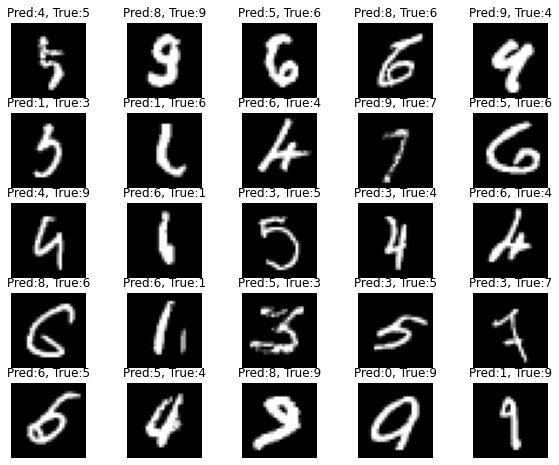

In [12]:
#Plot the false predictions
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5

for i in range(1, cols * rows+1):
    plot_pred, plot_true, plot_image = false_predictions[i-1]
    figure.add_subplot(rows, cols, i)
    plt.imshow(plot_image.squeeze(), cmap="gray")
    plt.title(f"Pred:{plot_pred}, True:{plot_true}")
    plt.axis("OFF")
plt.show()

In [14]:
len(false_predictions)

146

100